In [1]:
import os
import sys
import pyrootutils

pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
sys.path.append('..')
sys.path.append('')


In [2]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.figure import Figure
from rdkit import Chem
from torch import Tensor


Root:

In [3]:
ROOT = str(pyrootutils.find_root())
FILES_FOLDER = "interpretation_files"
DATA_FOLDER = "data"


In [23]:
train_df = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_scaffold_train.csv")
val_df = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_scaffold_valid.csv")
test_df = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_scaffold_test.csv")

train_df_random = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_random_train.csv")
val_df_random = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_random_valid.csv")
test_df_random = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/ames_random_test.csv")

splits = pd.concat([train_df, val_df, test_df]).rename(columns={"Drug_ID": "id"})


In [24]:
distances = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/distances.csv")
entropies = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/entropies.csv")
importances = pd.read_csv(f"{ROOT}/{DATA_FOLDER}/importances.csv")


In [25]:
joint_distances = distances.rename(columns={"Unnamed: 0": "id"}).merge(splits, on="id", how="left")
joint_entropies = entropies.rename(columns={"Unnamed: 0": "id"}).merge(splits, on="id", how="left")
joint_importances = importances.rename(columns={"Unnamed: 0": "id"}).merge(splits, on="id", how="left")


Mappers

In [7]:
def general_mapper(**kwargs: list[str]) -> dict[str, list[str]]:
    return {"_".join(l): [*l] for l in list(itertools.product(*kwargs.values()))}

name_mapper = {
    "encoder_only_C2C": "C2C",
    "encoder_only_R2C": "R2C",
    "encoder_only_E2C": "E2C",
    "encoder_only_MC2C": "MC2C",
    "encoder_only_MR2C": "MR2C",
    "encoder_only_ME2C": "ME2C",
    "encoder_decoder_C2C": "C2C",
    "encoder_decoder_R2C": "R2C",
    "encoder_decoder_E2C": "E2C",
    "encoder_decoder_MC2C": "MC2C",
    "encoder_decoder_MR2C": "MR2C",
    "encoder_decoder_ME2C": "ME2C",
    "native": "Native",
    "untrained": "Untrained",
    "encoder_decoder_ME2C_256": "256",
    "encoder_decoder_ME2C_128": "128",
    "encoder_decoder_ME2C_64": "64",
    "encoder_decoder_ME2C_0_1": "10%",
    "encoder_decoder_ME2C_0_2": "20%",
    "encoder_decoder_ME2C_0_5": "50%",
    "encoder_decoder_ME2C_train": "Training data",
    "encoder_decoder_ME2C_random": "Random split",
    "encoder_decoder_ME2C_cnn": "CNN",
    "encoder_decoder_ME2C_enum": "Enumerated",
}


Specific element vs score

In [8]:
def count_atoms(smiles, atom_symbol):
    molecule = Chem.MolFromSmiles(smiles)
    return sum(1 for atom in molecule.GetAtoms() if atom.GetSymbol() == atom_symbol)


In [37]:
def plot_atom_number_vs_score(
    df: pd.DataFrame,
    rdkit_atom_symbol: Optional[str] = 'C',
    drug_col: Optional[str] = 'canonical_smiles',
    hue: str = "method",
    score_col: str = 'Score',
    save_figure_path: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    y_label: str = "score",
    title: Optional[str] = None,
    errorbar: Optional[str] = 'sd',
    drop_atom_numbers_that_only_occur_once: Optional[bool] = True,
) -> Figure:
    """
    errorbar can be 'sd' or 'None' or some other fancy seaborn stuff
    drop_atom_numbers_that_only_occur_once: useful if you want errorbars for all points
    """

    # get element amounts
    x_column_name = f'Number of {rdkit_atom_symbol} atoms'
    df[x_column_name] = df[drug_col].apply(lambda x: count_atoms(x, rdkit_atom_symbol))
    df[y_label] = df[score_col]

    # drop atom numbers that only occur once
    if drop_atom_numbers_that_only_occur_once:
        df = df.groupby(x_column_name).filter(lambda x: len(x) > 1)

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Plot
    sns.lineplot(data=df,x=x_column_name,y=y_label,hue=hue,errorbar=errorbar,ax=ax)
    ax.set_ylabel(f"{y_label}")

    # save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    # set title
    if title is not None:
        ax.set_title(title)

    return fig


In [46]:
figure_models = [
    "encoder_decoder_ME2C",
    "native", "untrained",
    "encoder_decoder_ME2C_random",
    "encoder_decoder_ME2C_cnn",
    "encoder_decoder_ME2C_enum",
    "encoder_decoder_ME2C_train",
]
figure_methods = ["ig", "shap","attention_maps", "rollout", "grad", "att_grad", "cat", "att_cat"]

distance_selection = (figure_models, figure_methods, ["full"])
entropy_selection = (figure_models, figure_methods, ["canon"], ["atom"])
importance_selection = (figure_models, figure_methods, ["canon"], ["hit_only"])

data = []
for df, selection in zip(
    [joint_distances, joint_entropies, joint_importances],
    [distance_selection, entropy_selection, importance_selection]
):
    distance_mapper = general_mapper(**{chr(i): v for i,v in enumerate(selection)})
    data_selection = ["_".join(l) for l in list(itertools.product(*selection))]
    figure_data = df[data_selection + list(splits.columns)]

    figure_data = pd.melt(figure_data, id_vars=splits.columns)
    figure_data["names"] = figure_data.variable.map(distance_mapper)
    figure_data[['names', 'methods', 'sections', "parts"][:len(selection)]] = pd.DataFrame(figure_data.names.tolist(), index=figure_data.index)
    figure_data['training'] = figure_data.names.map(name_mapper)
    data.append(figure_data)


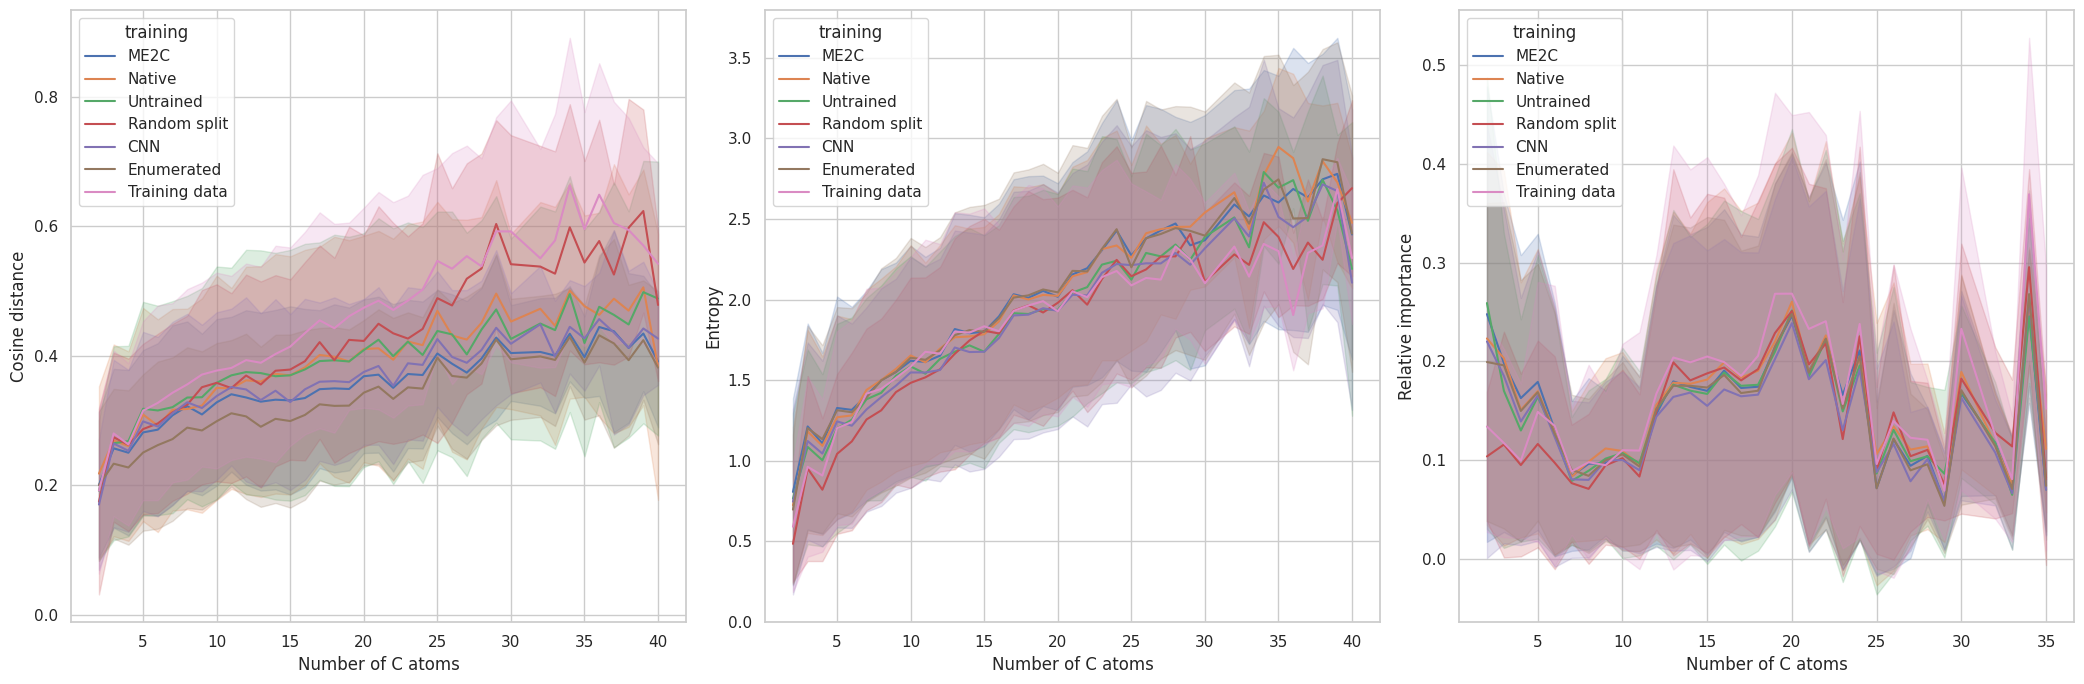

In [47]:
# Set figure size
plt.rcParams['figure.figsize'] = [21, 7]  # Width for 3 subfigures and height

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

plot_atom_number_vs_score(data[0], hue="training", score_col="value", ax=axs[0], y_label="Cosine distance")
plot_atom_number_vs_score(data[1], hue="training", score_col="value", ax=axs[1], y_label="Entropy")
plot_atom_number_vs_score(data[2], hue="training", score_col="value", ax=axs[2], y_label="Relative importance")



# Show
plt.tight_layout()
plt.show()


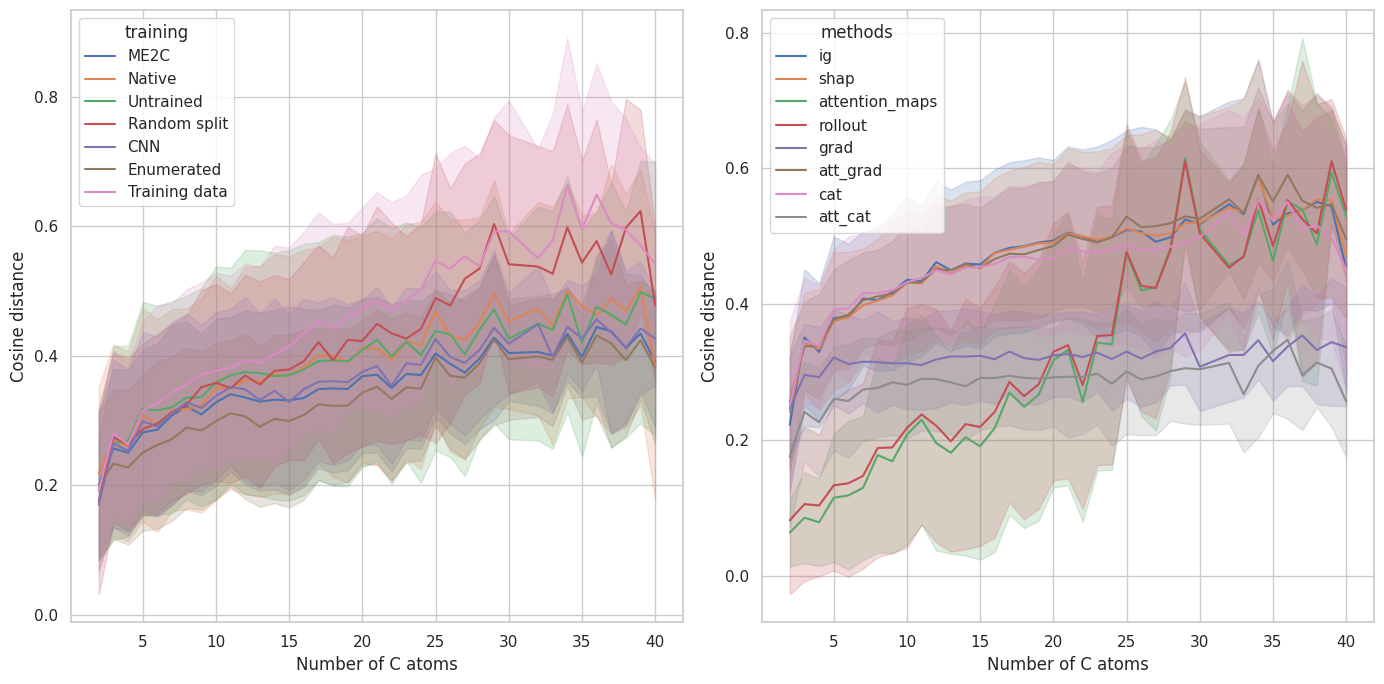

In [49]:
# Set figure size
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plot_atom_number_vs_score(data[0], hue="training", score_col="value", ax=axs[0], y_label="Cosine distance")
plot_atom_number_vs_score(data[0], hue="methods", score_col="value", ax=axs[1], y_label="Cosine distance")

# Show
plt.tight_layout()
plt.show()


In [43]:
figure_models = [
    "encoder_decoder_ME2C",
]
figure_methods = ["ig", "shap","attention_maps", "rollout", "grad", "att_grad", "cat", "att_cat"]

distance_selection = (figure_models, figure_methods, ["full"])
entropy_selection = (figure_models, figure_methods, ["canon"], ["atom"])
importance_selection = (figure_models, figure_methods, ["canon"], ["hit_only"])

data = []
for df, selection in zip(
    [joint_distances, joint_entropies, joint_importances],
    [distance_selection, entropy_selection, importance_selection]
):
    distance_mapper = general_mapper(**{chr(i): v for i,v in enumerate(selection)})
    data_selection = ["_".join(l) for l in list(itertools.product(*selection))]
    figure_data = df[data_selection + list(splits.columns)]

    figure_data = pd.melt(figure_data, id_vars=splits.columns)
    figure_data["names"] = figure_data.variable.map(distance_mapper)
    figure_data[['names', 'methods', 'sections', "parts"][:len(selection)]] = pd.DataFrame(figure_data.names.tolist(), index=figure_data.index)
    figure_data['training'] = figure_data.names.map(name_mapper)
    data.append(figure_data)


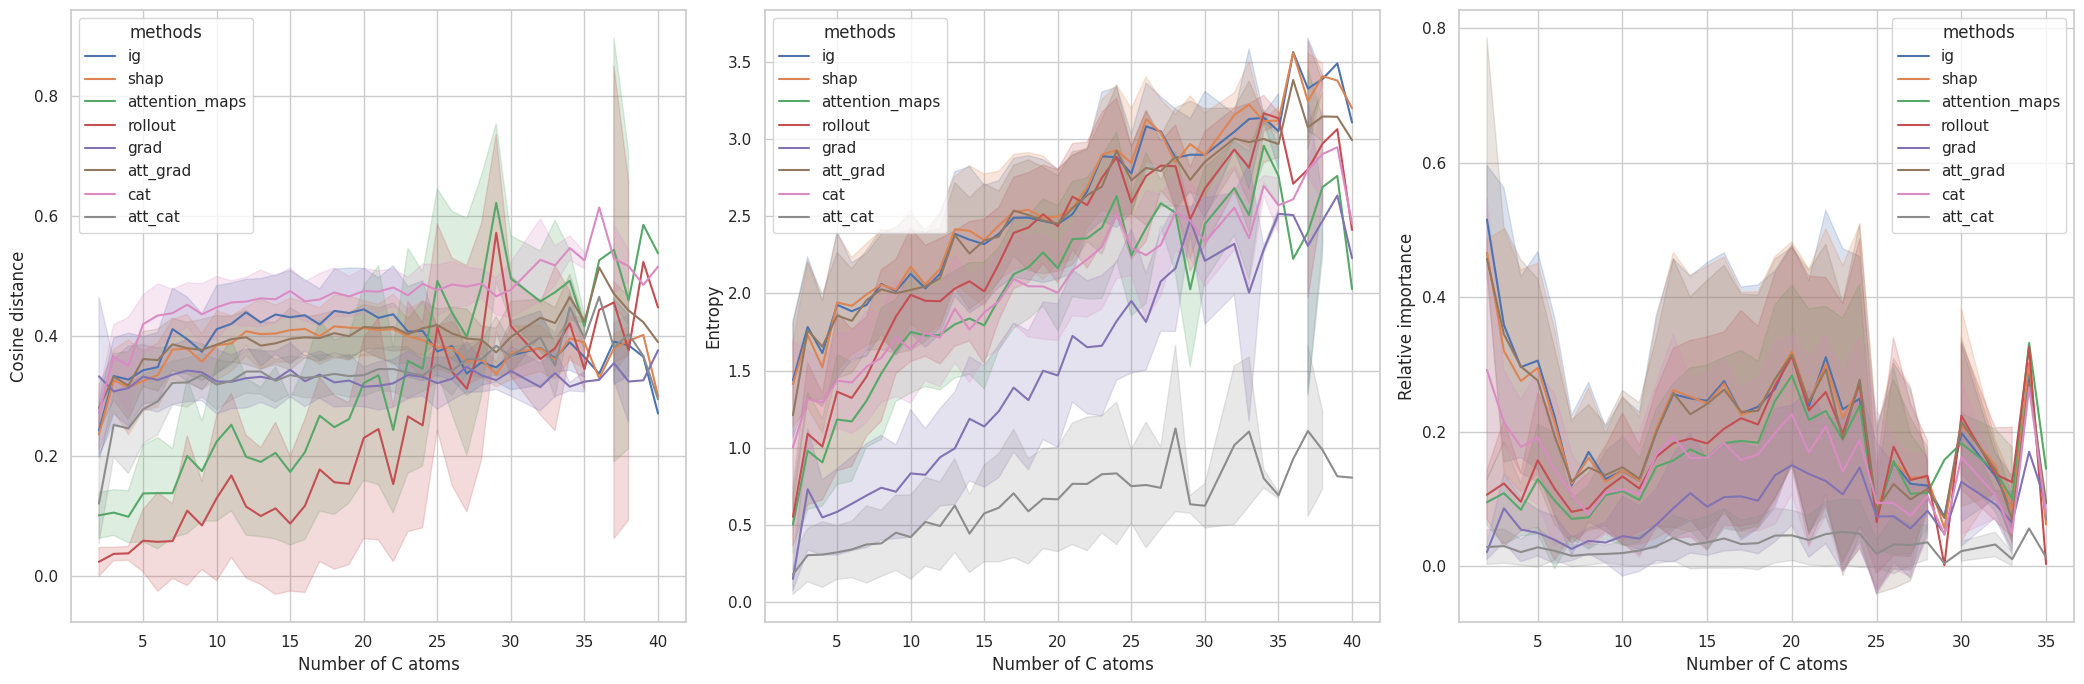

In [45]:
# Set figure size
plt.rcParams['figure.figsize'] = [21, 7]  # Width for 3 subfigures and height

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

plot_atom_number_vs_score(data[0], hue="methods", score_col="value", ax=axs[0], y_label="Cosine distance")
plot_atom_number_vs_score(data[1], hue="methods", score_col="value", ax=axs[1], y_label="Entropy")
plot_atom_number_vs_score(data[2], hue="methods", score_col="value", ax=axs[2], y_label="Relative importance")



# Show
plt.tight_layout()
plt.show()
